In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
"""
Load UCI ML Iris data
Return: data(shape = (150, 4)) and labels(shape = (150, 1)) in numpy array(rank 2)
"""
def load_data(classes):
    data = pd.read_csv('Iris.csv', index_col=0).as_matrix()
    features = data[:, :-1]
    labels = data[:, -1].reshape(-1, 1)
    for class_id in classes:
        labels[labels == class_id[0]] = class_id[1]
    return features.astype(np.float32), labels.astype(np.float32)

In [3]:
"""
Perform Data Shuffling
Return: shuffled features and labels
"""
def data_shuffling(features, labels):
    shuffle_array = np.random.permutation(features.shape[0])
    features = features[shuffle_array]
    labels = labels[shuffle_array]
    return features, labels

In [4]:
"""
Splitting the data into train and test set
Variable: ratio = percentage of data for train set
Return: train set and test set
"""
def data_split(features, labels, ratio=0.7):
    train_end_index = np.ceil(features.shape[0] * 0.7).astype(np.int32)
    train_features = features[:train_end_index]
    train_labels = labels[:train_end_index]
    test_features = features[train_end_index:]
    test_labels = labels[train_end_index:]
    return train_features, train_labels, test_features, test_labels

In [5]:
"""
Perform standardization for features
Return: standardized features, standard deviation, mean
"""
def standardization(features, exist_params=False, std=None, mean=None, colvar=True):
    features = features.T if not colvar else features
    if not exist_params:
        std = np.std(features, axis=0, keepdims=True)
        mean = np.mean(features, axis=0, keepdims=True)
    standard_features = (features - mean) / std
    return standard_features, std, mean

In [6]:
"""
Preparation of data, Performing shuffling, splitting, one-hotting
"""
def data_preparation(data, labels, classes):
    labels = np.eye(len(classes), dtype=np.float32)[np.squeeze(labels).astype(int)]
    data, labels = data_shuffling(data, labels)
    train_data = np.empty((0, data.shape[1]), dtype=np.float32)
    train_labels = np.empty((0, labels.shape[1]), dtype=np.float32)
    validation_data = np.empty((0, data.shape[1]), dtype=np.float32)
    validation_labels = np.empty((0, labels.shape[1]), dtype=np.float32)
    for each_class in classes:
        data_class = data[np.argmax(labels, axis=1).astype(np.float32) == float(each_class[1])]
        labels_class = labels[np.argmax(labels, axis=1).astype(np.float32) == float(each_class[1])]
        a, b, c, d = data_split(data_class, labels_class)
        train_data = np.append(train_data, a, axis=0)
        train_labels = np.append(train_labels, b, axis=0)
        validation_data = np.append(validation_data, c, axis=0)
        validation_labels = np.append(validation_labels, d, axis=0)
    train_data, train_labels = data_shuffling(train_data, train_labels)
    validation_data, validation_labels = data_shuffling(validation_data, validation_labels)
    train_data, std, mean = standardization(train_data)
    validation_data, _, _ = standardization(validation_data, exist_params=True, std=std, mean=mean)
    return train_data, train_labels, validation_data, validation_labels

In [7]:
"""
Sigmoid function
"""
def sigmoid(z):
    return 1 / (1 + np.exp(-z).astype(np.float32))

In [8]:
"""
Define the architecture of neural networks
"""
def neural_networks(x, w1, w2, b1, b2):
    Z1 = np.dot(x, w1) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(A1, w2) + b2
    A2 = sigmoid(Z2)
    return Z1, A1, Z2, A2

In [9]:
"""
Define the cost function MSE
"""
def mse(outputs, labels_smooth):
    return np.sum(np.sum(np.square((outputs - labels_smooth)) / 2, axis=0) / outputs.shape[0]) / outputs.shape[1]

In [10]:
"""
Compute the accuracy
"""
def get_accuracy(predictions, ground_truth):
    return np.mean(np.squeeze(predictions == ground_truth).astype(np.float32))

In [11]:
"""
Training of neural networks
"""
def training(train_data, train_labels, validation_data, validation_labels, learning_rate=0.1, epochs=3500):
    #Label smoothing#
    train_labels_smooth = np.copy(train_labels)
    validation_labels_smooth = np.copy(validation_labels)
    train_labels_smooth[train_labels_smooth == 1.] = 0.9
    train_labels_smooth[train_labels_smooth == 0.] = 0.1
    validation_labels_smooth[validation_labels_smooth == 1.] = 0.9
    validation_labels_smooth[validation_labels_smooth == 0.] = 0.1
    
    #Initialize the weights and bias#
    w1 = np.random.randn(2, 2).astype(np.float32)
    w2 = np.random.randn(2, 2).astype(np.float32)
    b1 = np.zeros((1, 2))
    b2 = np.zeros((1, 2))
    
    #Accuracy and cost history#
    accs = list()
    costs = list()
    accs_val = list()
    costs_val = list()
    
    #Save the initial training cost and accuracy#
    Z1, A1, Z2, A2 = neural_networks(train_data, w1, w2, b1, b2)
    costs.append(mse(A2, train_labels_smooth))
    accs.append(get_accuracy(np.argmax(A2, axis=1), np.argmax(train_labels, axis=1)))
    
    #Save the initial validation cost and accuracy#
    Z1, A1, Z2, A2 = neural_networks(validation_data, w1, w2, b1, b2)
    costs_val.append(mse(A2, validation_labels_smooth))
    accs_val.append(get_accuracy(np.argmax(A2, axis=1), np.argmax(validation_labels, axis=1)))
    
    #Training#
    for i in range(epochs):
        #Feed Forward#
        Z1, A1, Z2, A2 = neural_networks(train_data, w1, w2, b1, b2)
        
        #Back Propagation and Update weights, bias#
        dZ2 = np.multiply(np.multiply((A2 - train_labels_smooth), A2), (1 - A2))
        dZ1 = np.multiply(np.dot(dZ2, w2.T), np.multiply(A1, (1 - A1)))
        dw2 = np.dot(A1.T, dZ2) / train_data.shape[0]
        dw1 = np.dot(train_data.T, dZ1) / train_data.shape[0]
        db2 = np.sum(dZ2, axis=0)  / train_data.shape[0]
        db1 = np.sum(dZ1, axis=0) / train_data.shape[0]
        w1 = w1 - learning_rate * dw1
        w2 = w2 - learning_rate * dw2
        b1 = b1 - learning_rate * db1
        b2 = b2 - learning_rate * db2
        
        #Save the initial training cost and accuracy#
        Z1, A1, Z2, A2 = neural_networks(train_data, w1, w2, b1, b2)
        costs.append(mse(A2, train_labels_smooth))
        accs.append(get_accuracy(np.argmax(A2, axis=1), np.argmax(train_labels, axis=1)))

        #Save the initial validation cost and accuracy#
        Z1, A1, Z2, A2 = neural_networks(validation_data, w1, w2, b1, b2)
        costs_val.append(mse(A2, validation_labels_smooth))
        accs_val.append(get_accuracy(np.argmax(A2, axis=1), np.argmax(validation_labels, axis=1)))
    return w1, w2, b1, b2, costs, accs, costs_val, accs_val

In [12]:
"""
Plot the scatter graphs
"""
def plot_scatter(features, labels):
    plt.plot(features[np.squeeze(labels == float(1))][:, 0], features[np.squeeze(labels == float(1))][:, 1], 'gx', label='Iris-versicolor')
    plt.plot(features[np.squeeze(labels == float(2))][:, 0], features[np.squeeze(labels == float(2))][:, 1], 'bx', label='Iris-virginica')
    plt.title('Petal Length - Petal Width')
    plt.legend(loc='best')
    plt.show()

In [13]:
"""
Settings
"""
classes = [('Iris-setosa', 0), ('Iris-versicolor', 1), ('Iris-virginica', 2)]
cross_val_times = 100

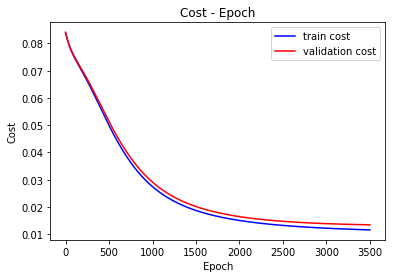

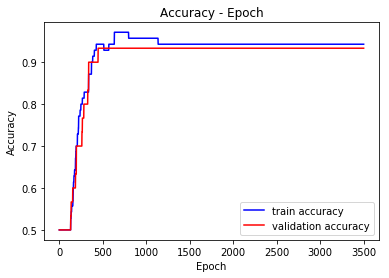

Average Accuracy (100 times): 0.9306666558980935


In [14]:
data, labels = load_data(classes)
data = data[np.logical_or(np.squeeze(labels == 1), np.squeeze(labels == 2))][:, 2:]
labels = labels[np.logical_or(np.squeeze(labels == 1), np.squeeze(labels == 2))] - 1.
classes = [('Iris-versicolor', 0), ('Iris-virginica', 1)]
cross_val_acc = 0.
for i in range(cross_val_times):
    train_data, train_labels, validation_data, validation_labels = data_preparation(data, labels, classes)
    w1, w2, b1, b2, costs, accs, costs_val, accs_val = training(train_data, train_labels, validation_data, validation_labels)
    cross_val_acc += accs_val[-1] / cross_val_times
plt.plot(costs, 'b-', label='train cost')
plt.plot(costs_val, 'r-', label='validation cost')
plt.title('Cost - Epoch')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()
plt.plot(accs, 'b-', label='train accuracy')
plt.plot(accs_val, 'r-', label='validation accuracy')
plt.title('Accuracy - Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()
print('Average Accuracy ({} times): {}'.format(cross_val_times, cross_val_acc))